<h1 style="text-align:center"> Report on TP6 : MNIST </h1> 
<h3 style="text-align:center"> LIUShaofeng </h3>

<font size = 3>

The paper by Burges and Schölkopf is investigating a method the improve the accuracy and speed of SVM. In this project, we first train a SVM with the same dataset (MNIST) with the kernel and the hyperparameter C they are suggesting, and then we will describe the technique they are using to improve the accuracy and implement it to see if it is working.
    
</font>

## 1. Load MNIST Dataset

<font size = 3>

We import the MNIST dataset by using ``tensorflow``. The ``tensorflow`` library imports the dataset from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz.
    
The MNIST dataset contains a collection of 70,000, 28 $\times$ 28 images of handwritten digits from 0 to 9, which means it contains:
+ sample : a 70000 $\times$ 28 $\times$ 28 array (70000 images, 28 $\times$ 28 pixels therefore 784 pixels for a image)
+ class : a one-dimensional array containing the class (digit label) for every image   
    
We use the function ``mnist.load_data`` to download the MNIST dataset and directly divide it into training set and test set.

    
</font>   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statistics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import time

In [6]:
mnist=np.load('mnist.npz')
mnist.files

['x_test', 'x_train', 'y_train', 'y_test']

In [7]:
X_train=mnist['x_train']
y_train=mnist['y_train']
X_test=mnist['x_test']
y_test=mnist['y_test']

print("Shape of X_train : ", X_train.shape)
print("Shape of X_test : ", X_test.shape)

Shape of X_train :  (60000, 28, 28)
Shape of X_test :  (10000, 28, 28)


<font size = 3>

Following the approach in TP4, we use the ``reshape`` function to reshape our training set and test set into a binary array (from 28$\times$28 to 784).
    
</font>  

In [8]:
X_train = X_train.reshape(X_train.shape[0],784)
X_test = X_test.reshape(X_test.shape[0],784)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [9]:
print("The size of training set sample X_train : ", X_train.shape)
print("The size of training set label y_train : ", y_train.shape)
print("The size of test set sample X_test : ", X_test.shape)
print("The size of test set label y_test : ", y_test.shape)

The size of training set sample X_train :  (60000, 784)
The size of training set label y_train :  (60000,)
The size of test set sample X_test :  (10000, 784)
The size of test set label y_test :  (10000,)


<font size =3>
    
We choose an example image randomly (index 12 in the training set), to see whether the digit image is loaded correctly.

</font>

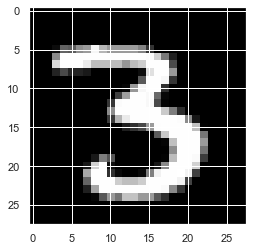

In [10]:
plt.imshow(X_train[12].reshape((28,28)),cmap=plt.get_cmap('gray'))

---

## 2. Experiment

<font size =3>

After reading the paper, we concluded that Burges and Schölkopf used the following steps to improve accuracy:
1. Trained 10 binary SVM classifiers using polynomial kernel to generate a set of support vectors.This 10-binary-SVM-classifiers system is called ORIG.
2. Use the support vector generated by the ORIG system to generate (by translating the generated support vector by one pixel in each of the four directions) new training data (virtual support vectors).
3. Train a new 10-binary-SVM-classifiers system by using the newly generated training data. This new system is called VSV.
    
</font>

### 2.1 Define the training function

<font size =3>
 
We define a function ``SVM_learning()`` to fit the model, calculate the training time and the test time and return the accuracy and the number of prediction errors of the model.
    
</font>

In [11]:
def SVM_learning(model, X_train , y_train, X_test, y_test):
    time_start_training = time.time()
    model.fit(X_train, y_train)
    time_finish_training = time.time()
    training_time = time_finish_training - time_start_training

    time_start_testing = time.time()
    y_pred = model.predict(X_test)
    time_finish_testing = time.time()
    testing_time = time_finish_testing - time_start_testing

    accuracy = accuracy_score(y_test, y_pred)
    nb_error = 10000-confusion_matrix(y_test, y_pred).trace()

    return model, training_time, testing_time, accuracy, nb_error

### 2.2 Generate new training data (virtual support vectors)

<font size =3>

In the function ``SVM_learning()``, we return the trained model (variable ``model``). We use this variable to obtain the support vector. After that, we define the function ``generate_virtual_support_vector()`` to generate virtual support variables. According to the narrative in the paper, by translating the generated support vector by one pixel in each of the four directions, we will get a new training set.
    
</font>

In [12]:
def generate_virtual_support_vector(sv):
    
    #Reshape the array from (nb_sv,784) to (nb_sv,28,28)
    sv_r = np.reshape(sv, (-1, 28, 28))#先转化成（sv数，28，28 ）
    
    #Generate variables to record new training data
    sv_zeros = np.zeros(sv_r.shape)#同规格（sv数，28，28），全0
    sv_left = sv_zeros.copy()
    sv_right = sv_zeros.copy()
    sv_up = sv_zeros.copy()
    sv_down = sv_zeros.copy()
    
    #According to the paper, generate new training data
    sv_left[:, :, 0:26] = sv_r[:, :, 1:27] #向左移一个pixel（保留后27列，最后一列全为0）
    sv_right[:, :, 1:27] = sv_r[:, :, 0:26] #向右移一个pixel（保留前27列，第一列全为0）
    sv_up[:, 0:26, :] = sv_r[:, 1:27, :]#向上移一个pixel（保留后27行，最后一行全为0）
    sv_down[:, 1:27, :] = sv_r[:, 0:26, :]#向下移一个pixel（保留前27行，第一行全为0）
    
    #Reshape the arrays from (nb_sv,28,28) to (nb_sv,784)
    #转化为（sv数，784）
    sv_l = np.reshape(sv_left, sv.shape) 
    sv_r = np.reshape(sv_right, sv.shape)
    sv_u = np.reshape(sv_up, sv.shape)
    sv_d = np.reshape(sv_down, sv.shape)
    
    #Concatenate these arrays by column and return the result (the shape of the result is (nb_sv * 4, 784))
    #拼接并输出
    new_training_data = np.concatenate((sv_l,sv_r,sv_u,sv_d),axis=0)
    
    return new_training_data

### 2.3 From ORIG to VSV

<font size =3>

We use the new training set obtained by the above function to train the system ORIG and the system VSV respectively. Because we need to train 10 binary SVM classifiers, we use an iterative loop to train 10 times. We also need to transform our variables ``y_train`` and ``y_test``: for each digit, all the correct targets are set to be 1, and false targets are set to be -1.
    
We use the following variables to record the information returned by the two methods (ORIG / VSV): 
1. ``orig_train_time/vsv_train_time``: list of the training time for each digit
2. ``orig_test_time/vsv_test_time``: list of the test time for each digit
3. ``orig_acc/vsv_acc``: list of the test time for each digit
4. ``orig_nb_err/vsv_nb_err``: list of the number of prediction errors for each digit
5. ``orig_nb_sv/vsv_nb_sv``: list of the number of support vectors for each digit
</font>

In [13]:
orig_train_time = []
orig_test_time = []
orig_acc = []
orig_nb_err = []
orig_nb_sv = []

vsv_train_time = []
vsv_test_time = []
vsv_acc = []
vsv_nb_err = []
vsv_nb_sv = []

In [14]:
for i in range(0,10):
    
    #转换为1，-1形式
    y_train_binary = y_train.copy()
    y_train_binary[y_train_binary != i] = -1
    y_train_binary[y_train_binary == i] = 1
    y_test_binary = y_test.copy()
    y_test_binary[y_test_binary != i] = -1
    y_test_binary[y_test_binary == i] = 1
    
    model = SVC(kernel='poly', gamma='auto', degree=5, C=10)

    ################ ORIG ###################
    
    # Training ORIG
    orig, train_time_orig, test_time_orig, acc_orig, nb_error_orig = SVM_learning(model,X_train,y_train_binary,X_test,y_test_binary)
    sv_orig = orig.support_vectors_
    y_sv = y_train_binary[orig.support_]#support_：Indices of support vectors.是sv的样本（x）的编号
    
    # Store the information
    orig_train_time.append(train_time_orig)
    orig_test_time.append(test_time_orig)
    orig_acc.append(acc_orig)
    orig_nb_err.append(nb_error_orig)
    orig_nb_sv.append(sv_orig.shape[0])
    
    
    ################ VSV ###################
    
    # Generate new training data
    X_train_binary_vsv = generate_virtual_support_vector(sv_orig)
    y_train_binary_vsv = np.concatenate((y_sv,y_sv,y_sv,y_sv),axis=0) #重复4次，变为（nb_sv * 4,）
    
    # Training VSV
    vsv, train_time_vsv, test_time_vsv, acc_vsv, nb_error_vsv = SVM_learning(model, X_train_binary_vsv,y_train_binary_vsv,X_test,y_test_binary)
    sv_vsv = vsv.support_vectors_
    
    # Store the information
    vsv_train_time.append(train_time_vsv)
    vsv_test_time.append(test_time_vsv)
    vsv_acc.append(acc_vsv)
    vsv_nb_err.append(nb_error_vsv)
    vsv_nb_sv.append(sv_vsv.shape[0])
    
    # Print
    print('Digit ',i)
    print('******************************************')
    print('ORIG training time : ', train_time_orig)
    print('ORIG testing time : ', test_time_orig)
    #print('Number of Support Vectors of ORIG :',sv_orig.shape[0])
    print('Accuracy ORIG : ',acc_orig)
    print('******************************************')
    print('VSV training time : ', train_time_vsv)
    print('VSV testing time : ', test_time_vsv)
    #print('Number of Support Vectors of VSV :',sv_vsv.shape[0])
    print('Accuracy VSV : ',acc_vsv)
    print('---------------------------------------------------')

Digit  0
******************************************
ORIG training time :  308.7448625564575
ORIG testing time :  16.133331298828125
Accuracy ORIG :  0.9958
******************************************
VSV training time :  59.66461753845215
VSV testing time :  37.0274453163147
Accuracy VSV :  0.9976
---------------------------------------------------
Digit  1
******************************************
ORIG training time :  210.69409275054932
ORIG testing time :  12.573699474334717
Accuracy ORIG :  0.9959
******************************************
VSV training time :  23.85472011566162
VSV testing time :  28.434986352920532
Accuracy VSV :  0.9967
---------------------------------------------------
Digit  2
******************************************
ORIG training time :  533.1421461105347
ORIG testing time :  26.294262170791626
Accuracy ORIG :  0.9923
******************************************
VSV training time :  198.496435880661
VSV testing time :  58.28010892868042
Accuracy VSV :  0.9947

<font size =3>

We generate a plot to compare the accuracy of the two methods. Following the example in the paper, we also generate a table to show the results of our experiment.
    
</font >

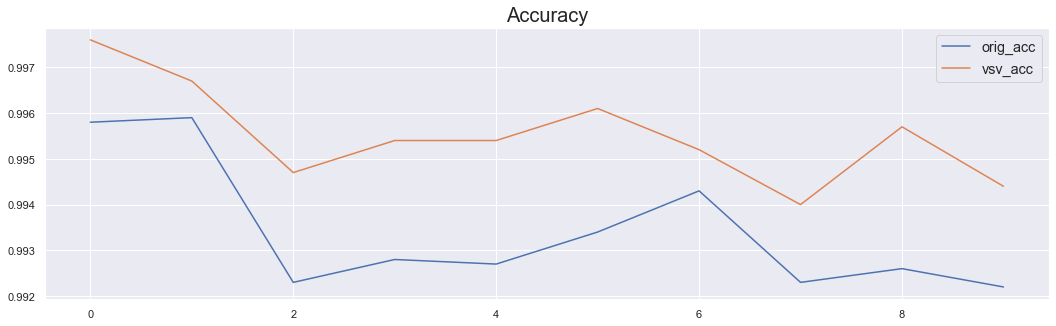

In [15]:
sns.set(rc={'figure.figsize':(18,5)}) 
plt.plot(orig_acc, label='orig_acc')
plt.plot(vsv_acc, label='vsv_acc')
plt.legend(loc='upper right', fontsize='large', title_fontsize='40')
plt.title('Accuracy', size=20)
plt.show()

In [16]:
acc_improvement = statistics.mean( [vsv_acc[i] - orig_acc[i] for i in range(len(vsv_acc))])
print(acc_improvement)

0.002090000000000003


### Table : Generalization Performance Improvement by Incorporating Invariance. 

In [17]:
table = {"Ne ORIG" : orig_nb_err,
         "Ne VSV" : vsv_nb_err,
         "Nsv ORIG" : orig_nb_sv, 
         "Nsv VSV" : vsv_nb_sv, 
         "Accuracy ORIG" : orig_acc,
         "Accuracy VSV" : vsv_acc
             }
table = pd.DataFrame(table)
print(table)

   Ne ORIG  Ne VSV  Nsv ORIG  Nsv VSV  Accuracy ORIG  Accuracy VSV
0       42      24      1760     4000         0.9958        0.9976
1       41      33      1393     3063         0.9959        0.9967
2       77      53      2856     6456         0.9923        0.9947
3       72      46      3159     7101         0.9928        0.9954
4       73      46      2431     5474         0.9927        0.9954
5       66      39      2746     6392         0.9934        0.9961
6       57      48      1802     4049         0.9943        0.9952
7       77      60      2381     5500         0.9923        0.9940
8       74      43      3548     8344         0.9926        0.9957
9       78      56      3377     7938         0.9922        0.9944


---

## 3. Conclusion

<font size =3>

From the plot and the table, we can see that the number of errors of the VSV is smaller than ORIG's and the accuracy of the VSV method is better than that of the ORIG method. This shows that our experimental results are consistent with the results in the paper of Burges and Schölkopf. Through calculation, we can see that the VSV method improves the accuracy by 0.2% compared with the ORIG method.
    
For the conclusion, we can explain that virtual support vector technique is working in terms of improving the accuracy.
    
    
    
</font >

<font size =3>

**Reference** : [*Improving the Accuracy and Speed of Support Vector Machines*   Chris J.C. Burges and Bernhard Scholkopf.](https://proceedings.neurips.cc/paper/1996/file/b495ce63ede0f4efc9eec62cb947c162-Paper.pdf).
    
</font>